In [1]:
import os
if os.name != 'posix':
    %matplotlib ipympl
else:
    %matplotlib notebook
import scipy.constants as sc
from scipy.optimize import fsolve

import numpy as np
import cmath
import matplotlib.pyplot as plt
import scipy.constants as sc
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
import h5py

print(os.getpid())
%cd ../../

import pylib.mix as mix
import pylib.measurement as mse

21185
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# --- Launch to change cells' width ---
from IPython.display import display, HTML
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
display(HTML("<style>.container { width:100% !important; }</style>"))

colors_ = ["blue", "red", "green", "gray", "black"]

from matplotlib import ticker
cmap_two_signs_= 'coolwarm'
cmap_two_signs_= 'Blues'
# cmap_two_signs_= 'Greys'
# cmap_two_signs_= 'Pastel1'
# cmap_two_signs_= 'flag'
# cmap_two_signs_= 'nipy_spectral'
# cmap_two_signs_= 'jet'
# cmap_two_signs_= 'seismic'
def fmt_(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

for i in range(30):
    plt.close()

<IPython.core.display.Javascript object>


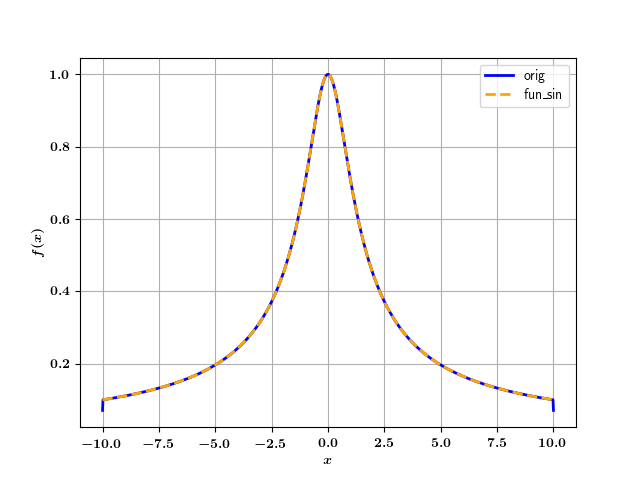

In [4]:
# -------------------------------------------------------------------
# --- Plot weights --- 
# -------------------------------------------------------------------
mix.reload_module(mix)

nk_ = 10
Nk_ = 1 << nk_
k_max_ = 10.

Hadamart_norm_factor_ = 2**(nk_/2) # the rescaling factor appears to the initialization circuit;
qsvt_rescaling = 0.98
coef_norm_ = Hadamart_norm_factor_ / qsvt_rescaling

k = np.linspace(-k_max_, k_max_, Nk_)
orig_fun_ = np.sqrt(1./ (1 + k**2))
orig_fun_[0] *= np.sqrt(0.5)
orig_fun_[-1] *= np.sqrt(0.5)

k_11 = np.linspace(-1.0, 1.0, Nk_)
fun_11 = np.sqrt(1./ (1 + k_max_**2 * k_11**2))

x_sin = np.sin(k_11)
fun_sin = np.sqrt(1./ (1 + k_max_**2 * np.arcsin(x_sin)**2))

# --- Plotting ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k, orig_fun_, color='b', linewidth = 2, linestyle='-',  label = "orig")
# ax.plot(k_11 * k_max_, fun_11,  color='r', linewidth = 2, linestyle='--',  label = "fun_11")
ax.plot(k_11 * k_max_, fun_sin, color='orange', linewidth = 2, linestyle='--',  label = "fun_sin")
plt.xlabel('$x$')
plt.ylabel("$f(x)$")
ax.legend()
plt.grid(True)
plt.show()

In [6]:
# ---------------------------------------------------------
# --- Compute angles for circuit ---
# ---------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)
from scipy.optimize import fsolve

def compute_corr():
    # !!! Attention !!!
    # the correction angles is computed from a QuCF computation performed
    # without the correcting gates:
    
    om = mse.MeasOracle__(True)
    om.path_ = "../QuCF/tests/compute-LCHS-weights/"
    om.pname_ = "weights"
    om.open()
    om.set_work_states(0)
    res_k0 = om.get_var_x({"a_be": 0, "rk": 0}, "a_qsvt") 
    
    def func_to_solve(x):
        aa = res_k0[0]
        aas = res_k0[1]
        return [aa * np.cos(x[0]/2.) - 1j*np.sin(x[0]/2.)*aas - aa / np.sqrt(2.)]

    res = fsolve(func_to_solve, [0.1])
    
    print("recheck: {:20.3e}".format(func_to_solve(res)[0]))
    print()
    
    return res[0] 
# -------------------------------------------------------

# --- for the x-grid ---
alpha_k0 = - 1.0
alpha_k1 = Nk_/(Nk_ - 1)

# --- correction ---
alpha_k_corr = compute_corr()

print("nk \t{:d}".format(nk_))
print("alpha_k0 \t{:0.12e}".format(alpha_k0))
print("alpha_k1 \t{:0.12e}".format(alpha_k1))
print("alpha_k_corr \t{:0.12e}".format(alpha_k_corr))

del alpha_k0, alpha_k1

Reading the file ../QuCF/tests/compute-LCHS-weights//weights_OUTPUT.hdf5...
Name of the simulation is weights
Simulation has been performed  01-09-2024 14:52:15
recheck: 0.000e+00+0.000e+00j

nk 	10
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.000977517107e+00
alpha_k_corr 	9.505249742429e-02


Reading the file ../QuCF/tests/compute-LCHS-weights//weights_OUTPUT.hdf5...
Name of the simulation is weights
Simulation has been performed  01-09-2024 15:32:33


<IPython.core.display.Javascript object>


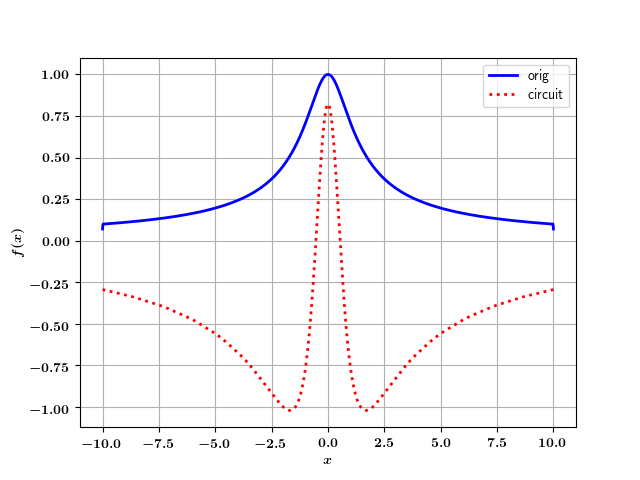

In [43]:
# --------------------------------------------------------------
# --- Plot the results from the QSVT LCHS weights simualtion ---
# --------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(mse)

om = mse.MeasOracle__(True)

om.path_ = "../QuCF/tests/compute-LCHS-weights/"
om.pname_ = "weights"
om.open()
om.read_qsvt()

# read k-max
k_max_c = om.dd_["weights"]["par"]

# form k-grid
nk_c = om.dd_["regs"]["rk"]
Nk_c = 1 << nk_c
k_grid_c = np.linspace(-1., 1., Nk_c);

# output state
# om.set_zero_ancillae_work_states(0)
# weights_c = om.get_var_x({}, "rk")

om.set_work_states(0)
weights_c = om.get_var_x({"a_be": 0, "a_qsvt": 0, "aref": 0}, "rk")


# --- Plot the results ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(
    k, orig_fun_, 
    color='b', linewidth = 2, linestyle='-',  
    label = "orig"
)
ax.plot(
    k_grid_c * k_max_c, coef_norm_*weights_c, 
    color='r', linewidth = 2, linestyle=':',  
    label = "circuit"
)
plt.xlabel('$x$')
plt.ylabel("$f(x)$")
ax.legend()
plt.grid(True)
plt.show()

In [40]:
np.sqrt(np.sum(np.abs(weights_c)**2))

0.7249424786742176

In [36]:
np.cos(2.6/2.)

0.2674988286245874

In [41]:
mix.reload_module(mix)
mix.reload_module(mse)

om = mse.MeasOracle__(True)

om.path_ = "../QuCF/tests/compute-LCHS-weights/"
om.pname_ = "weights"
om.open()
om.read_qsvt()

# read k-max
k_max_c = om.dd_["weights"]["par"]

# form k-grid
nk_c = om.dd_["regs"]["rk"]
Nk_c = 1 << nk_c
k_grid_c = np.linspace(-1., 1., Nk_c);

# output state
om.set_work_states(0)
res_k0 = om.get_var_x({"a_be": 0, "rk": 0}, "a_qsvt")

print(res_k0)
print(orig_fun_[0] * np.sqrt(2.0) / coef_norm_)

Reading the file ../QuCF/tests/compute-LCHS-weights//weights_OUTPUT.hdf5...
Name of the simulation is weights
Simulation has been performed  01-02-2024 16:33:38
[0.003+0.j    0.   -0.019j]
0.003047301395018092


nk 	10
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.000977517107e+00


In [26]:
# ---------------------------------------------------------
# --- Compare SIN with circuit computation ---
# Launch this only if the weights.oracle simulates only the sin-gate without QSVT adn INIT circuits, and 
#    if flag_matrix 1
# ---------------------------------------------------------
mix.reload_module(qucf_r)

print()
dd_sin_test = qucf_r.read_matrix_sparse(
    "../QuCF/tests/compute-LCHS-weights/", 
    "weights_OUTPUT.hdf5"
) 


# --- compare the grid computed by the circuit and the original grid:
print()
print("Absolute errors:")
max_abs_err = 0.
for ii in range(len(dd_sin_test["A"].get_values())):
    res = np.sin(-1.0 + 2./(Nk_ - 1) * ii)
    abs_err = np.abs(res - dd_sin_test["A"].get_values()[ii].real)
    if abs_err > max_abs_err:
        max_abs_err = abs_err
    if abs_err > 1e-12:
        print("{:d}: abs. err = {:0.3e}".format(ii, abs_err))
print("max. abs. error: {:0.3e}".format(max_abs_err))        
del ii, abs_err, res, max_abs_err


# for ik in range(Nk_):
#     res = np.sin(-1.0 + 2./(Nk_ - 1) * ik)
#     print("{:d}: sin = {:0.3e}".format(ik, res))
# del ik, res


Reading the matrix from: weights_OUTPUT.hdf5
from the path: ../QuCF/tests/compute-LCHS-weights/
date of the simulation:  12-08-2023 10:24:56
matrix name:  U
N = 1024

Absolute errors:
max. abs. error: 5.952e-13


In [70]:
# -------------------------------------------------------------
# --- Scaling of the circuit realisation of the weights ---
# $qucf_pol -sel_function sqrt_inv_arcsin2 -param 10 -Nd 95
# -------------------------------------------------------------
mix.reload_module(mix)

def save_data_eps(Nd, eps, kmax_in):
    path_save = "./jupyter-notebooks/NL/results"
    
    N_angles = 2 * (np.array(Nd)/2) - 1
    log_eps = -np.log10(eps) 
    
    mix.save_dat_plot_1d_file(
        path_save + "/scan_Na_eps_kmax{:d}.dat".format(kmax_in), 
        log_eps, 
        N_angles
    )
    return

def get_data_eps(Nd, eps):
    N_angles = 2 * (np.array(Nd)/2) - 1
    log_eps = np.log10(eps) 
    return N_angles, log_eps
# -------------------------------------------------------------------------

kmax_s = 10
abs_errors = [2.378e-3, 1.512e-04, 1.178e-04, 6.447e-05, 4.188e-05, 2.514e-05, 1.120e-05]
Nd_pol     = [      50,       120,       150,       250,       350,       500,      1000]
save_data_eps(Nd_pol, abs_errors, kmax_s)


kmax_s = 20
abs_errors = [2.242e-03, 1.555e-04,  2.575e-05, 1.479e-05, 1.263e-05, 5.628e-06]
Nd_pol     = [      100,       150,        300,       450,       500,      1000]
save_data_eps(Nd_pol, abs_errors, kmax_s)


kmax_s = 40
abs_errors = [2.185e-03, 1.507e-04, 1.085e-05, 4.793e-06, 3.541e-06, 2.817e-06]
Nd_pol     = [      200,       300,       400,       600,       800,      1000]
save_data_eps(Nd_pol, abs_errors, kmax_s)


kmax_s = 60
abs_errors = [2.165e-03, 1.495e-04, 1.079e-05, 2.361e-06, 1.878e-06]
Nd_pol     = [      300,       450,       600,       800,      1000]
save_data_eps(Nd_pol, abs_errors, kmax_s)


kmax_s = 80
abs_errors = [2.156e-03, 1.489e-04, 1.075e-05, 1.405e-06]
Nd_pol     = [      400,       600,       800,      1000]
save_data_eps(Nd_pol, abs_errors, kmax_s)

del kmax_s, abs_errors, Nd_pol

write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax10.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax20.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax40.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax60.dat
write data to a file: ./jupyter-notebooks/NL/results/scan_Na_eps_kmax80.dat


In [68]:

!../QuCF/build_polynomial/approx_polyn -sel_function sqrt_inv_arcsin2 -param 80 -Nd 2000 -work_path ../QuCF/tests/compute-angles/LCHS_weights/coefs/


--- Fourier approach ---
Function to approximate: sqrt_inv_arcsin2
Its parity: 	0
Parameter: 	80
Rescaling parameter: 	0.98
Nd: 	2000
N of avail. GPU devices: 1
Avail. GPU mem for coefs. (MB): 7164

---
Required mem. for coefs. (MB): 0.0152588

	 *** Iteration: 0 ***
	N-coefs per device: 1000
	N-blocks: 1
	N-threads: 1000

Construction of the polynomial...
Resulting approximation error: 5.839e-07
Data are saved to the file: ../QuCF/tests/compute-angles/LCHS_weights/coefs//sqrt_inv_arcsin2_80.000000_6.hdf5


In [ ]:
!../QuCF/build_angles/compute_angles 

In [ ]:
# -------------------------------------------------------------------
# --- Plot weights --- 
# -------------------------------------------------------------------
mix.reload_module(mix)

nk = 10
Nk = 1 << nk
k_max = 10.

k = np.linspace(-k_max, k_max, Nk)
orig_fun = np.sqrt(1./ (1 + k**2))

# k_grad1 = np.linspace(-1, 1, Nk)
# orig_fun_grad1 = np.sqrt(1./ (1 + k_grad1**2))

degree = 8
# fit_coefficients = np.polyfit(k, orig_fun, degree)
# pol_approx = np.polyval(fit_coefficients, k)

fit_coefficients = np.polynomial.Chebyshev.fit(k, orig_fun, deg = 10)
# pol_approx = np.polynomial.Chebyshev(fit_coefficients, k)

fit_coefficients


# --- Plotting ---
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(k, orig_fun, color='b', linewidth = 2, linestyle='-',  label = "orig")
# ax.plot(k, pol_approx, color='r', linewidth = 2, linestyle='-',  label = "pol")
plt.xlabel('$x$')
plt.ylabel("$f(x)$")
ax.legend()
plt.grid(True)
plt.show()

In [6]:
fit_coefficients.convert().coef

array([ 6.232e-01,  0.000e+00, -2.195e-02,  0.000e+00,  1.211e-04,
        0.000e+00, -2.072e-07])

In [14]:
fit_coefficients.linspace(100)

(array([-10.   ,  -9.798,  -9.596,  -9.394,  -9.192,  -8.99 ,  -8.788,
         -8.586,  -8.384,  -8.182,  -7.98 ,  -7.778,  -7.576,  -7.374,
         -7.172,  -6.97 ,  -6.768,  -6.566,  -6.364,  -6.162,  -5.96 ,
         -5.758,  -5.556,  -5.354,  -5.152,  -4.949,  -4.747,  -4.545,
         -4.343,  -4.141,  -3.939,  -3.737,  -3.535,  -3.333,  -3.131,
         -2.929,  -2.727,  -2.525,  -2.323,  -2.121,  -1.919,  -1.717,
         -1.515,  -1.313,  -1.111,  -0.909,  -0.707,  -0.505,  -0.303,
         -0.101,   0.101,   0.303,   0.505,   0.707,   0.909,   1.111,
          1.313,   1.515,   1.717,   1.919,   2.121,   2.323,   2.525,
          2.727,   2.929,   3.131,   3.333,   3.535,   3.737,   3.939,
          4.141,   4.343,   4.545,   4.747,   4.949,   5.152,   5.354,
          5.556,   5.758,   5.96 ,   6.162,   6.364,   6.566,   6.768,
          6.97 ,   7.172,   7.374,   7.576,   7.778,   7.98 ,   8.182,
          8.384,   8.586,   8.788,   8.99 ,   9.192,   9.394,   9.596,
      

<IPython.core.display.Javascript object>


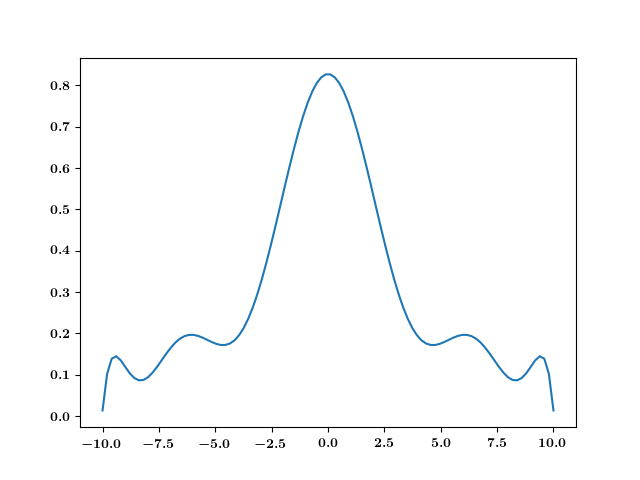

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(fit_coefficients.linspace(100)[0], fit_coefficients.linspace(100)[1])

<IPython.core.display.Javascript object>


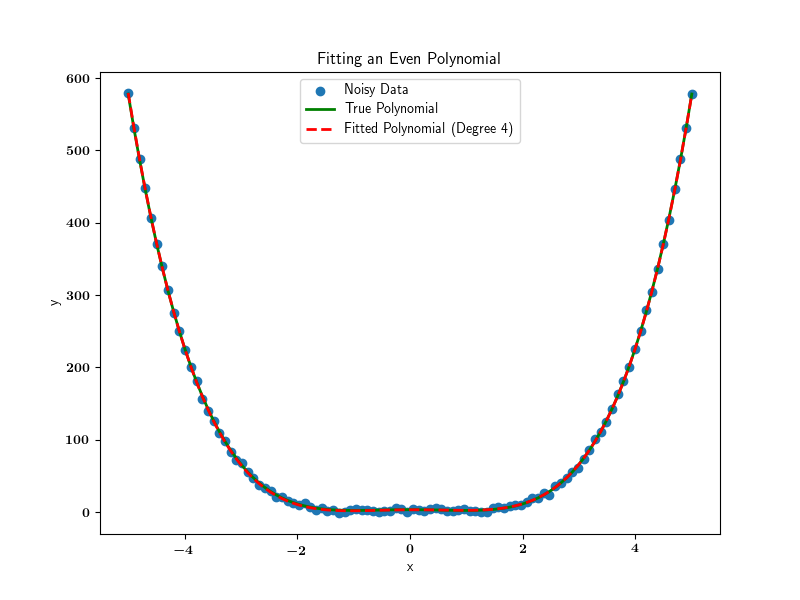

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Generate sample data
x = np.linspace(-5, 5, 100)
true_coefficients = [1, 0, -2, 0, 3]  # Coefficients of the even polynomial: 1*x^4 + 0*x^3 - 2*x^2 + 0*x - 3
y_true = np.polyval(true_coefficients, x)

# Add some noise to the data
np.random.seed(42)
noise = np.random.normal(0, 2, size=len(x))
y_noisy = y_true + noise

# Fit even polynomial (4th degree in this case) to the noisy data
degree = 4
fit_coefficients = np.polyfit(x, y_noisy, degree)

# Generate the fitted curve
y_fit = np.polyval(fit_coefficients, x)

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(x, y_noisy, label='Noisy Data')
plt.plot(x, y_true, label='True Polynomial', linewidth=2, color='green')
plt.plot(x, y_fit, label=f'Fitted Polynomial (Degree {degree})', linestyle='--', linewidth=2, color='red')
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitting an Even Polynomial')
plt.show()